<a href="https://colab.research.google.com/github/imanhamid/selectionscan_NN/blob/master/segmentation_unlabeled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

In [3]:
path = Path(base_dir + 'data/segmentation/')

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

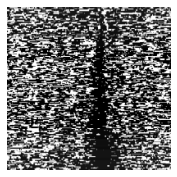

In [6]:
img_f = fnames[100]
img = open_image(img_f)
img.show()

In [7]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

print(get_y_fn(img_f))

/content/gdrive/My Drive/fastai-v3/data/segmentation/labels/const-10000_single-pulse_gen-100_m-0.5_pos-57420120_t-1_s-0.1164983978495_seed-200_alltracts_P.png


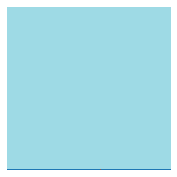

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(alpha=1)

Bottom row is labeled as 0: neutral and 1: sweep (it's hard to see the single pixel labeled as sweep, but it's there)

In [ ]:
#torch.set_printoptions(profile="full")
#print(mask.data) # prints the whole tensor
#torch.set_printoptions(profile="default") # reset

In [9]:
src_size = np.array(mask.shape[1:]) #confirm mask labels are 0: neutral, 1: sweep, 2: unabeled
src_size, mask.data

(array([200, 200]), tensor([[[2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2],
          ...,
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [10]:
codes = np.array(['neutral', 'sweep', 'unlabeled'], dtype=str)

In [11]:
free = gpu_mem_get_free_no_cache()
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")



using bs=8, have 11430MB of GPU RAM free


In [12]:
src = (SegmentationItemList.from_folder(path_img)
        .split_subsets(train_size = 0.8, valid_size = 0.2)
        .label_from_func(get_y_fn, classes=codes))
data = (src.databunch(bs=bs)
        .normalize())

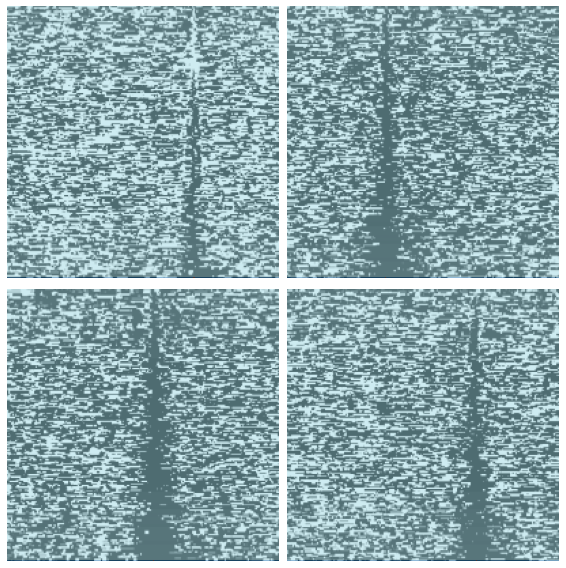

In [13]:
data.show_batch(2)

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['unlabeled']

def acc_unlabeled(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

^ define new accuracy metric to ignore unlabeled pixels when calculated % correctly labeled pixels. This will not affect training.

In [18]:
learn = unet_learner(data, models.resnet18, metrics=[dice,acc_unlabeled], loss_func=CrossEntropyFlat(axis=1, 
                    weight=torch.tensor([1.,1.,0.]).cuda()), wd=1e-2)

^ redefine loss function to ignore unabeled pixels when calculating loss. Neutral and sweep pixels (bottom row) are weighted equally.

epoch,train_loss,valid_loss,dice,acc_unlabeled,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


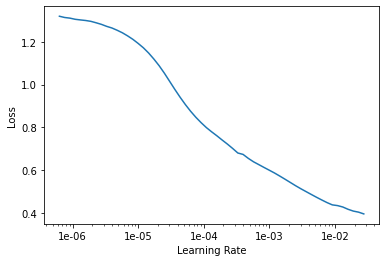

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
lr = 3e-5

In [21]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice,acc_unlabeled,time
0,0.478992,0.102460,1.166869,0.984575,01:38
1,0.112785,0.052081,1.172806,0.994075,01:01
2,0.042543,0.025667,0.511266,0.995000,01:00
3,0.024123,0.020577,0.537425,0.995000,01:00
4,0.019356,0.018699,0.684788,0.994975,01:00
5,0.017842,0.019123,0.331177,0.995000,01:01
6,0.016656,0.017138,0.961480,0.994700,01:01
7,0.016061,0.016499,0.294318,0.994975,01:00
8,0.015261,0.016654,0.330323,0.994925,01:01
9,0.013854,0.015982,0.222039,0.994975,01:00


In [35]:
learn.unfreeze()

In [36]:
lrs = slice(lr/400, lr/4)

In [37]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,acc_unlabeled,time
0,0.012565,0.015834,0.233461,0.994975,01:03
1,0.012328,0.015757,0.242531,0.994975,01:02
2,0.012224,0.015814,0.217051,0.994850,01:03
3,0.011986,0.016144,0.160867,0.994975,01:03
4,0.011819,0.016585,0.140450,0.994800,01:04
5,0.011376,0.016506,0.155872,0.994825,01:03
6,0.011116,0.017441,0.115881,0.994900,01:02
7,0.010705,0.017082,0.132936,0.994750,01:03
8,0.010500,0.016458,0.116698,0.994325,01:03
9,0.009915,0.017213,0.098511,0.994225,01:03


It's started overfitting at this point (training loss decreasing, validation loss increasing), so I should have probably stopped training.

In [46]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,acc_unlabeled,time
0,0.008387,0.018602,0.074346,0.994500,01:02
1,0.008334,0.018593,0.074521,0.994500,01:03
2,0.008325,0.018766,0.069806,0.994175,01:03
3,0.008204,0.019627,0.068399,0.994375,01:03
4,0.008184,0.019796,0.066760,0.994450,01:03
5,0.008029,0.019698,0.069753,0.994600,01:03
6,0.007878,0.021053,0.052898,0.994075,01:03
7,0.007799,0.020841,0.061756,0.993900,01:03
8,0.007805,0.020122,0.061924,0.994125,01:03
9,0.007460,0.021367,0.049929,0.994325,01:02


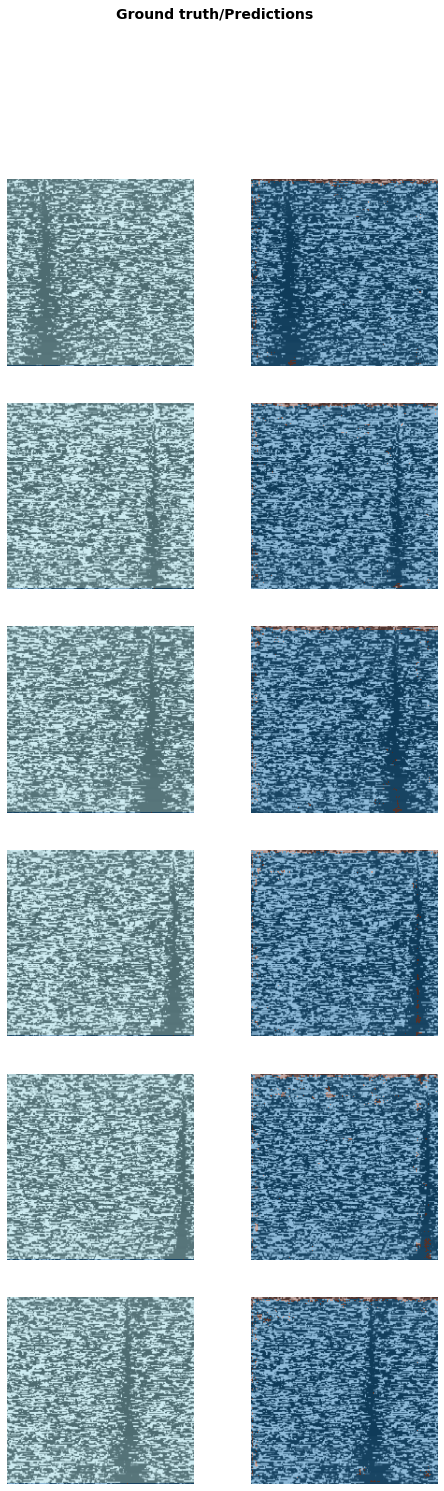

In [47]:
learn.show_results(rows=6)

It seems like it's starting to localize the sweep, though usually off by a few Mb, and it doesn't appear to be labeling pixels in the bottom row with sweeps, which is the row we are actually interested in. It also seems to be learning that edges = sweeps, and labeling other random positions as sweeps (possibly due to there only being 1 pixel among 40000 labeled as sweep).

In [23]:
class SegmentationInterpretation(Interpretation):
    "Interpretation methods for segmenatation models."
    def __init__(self, learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor,
                 ds_type:DatasetType=DatasetType.Valid):
        super(SegmentationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.pred_class = self.preds.argmax(dim=1)
        self.c2i = {c:i for i,c in enumerate(self.data.classes)}
        self.i2c = {i:c for c,i in self.c2i.items()}
    
    def top_losses(self, sizes:Tuple, k:int=None, largest=True):
        "Reduce flatten loss to give a single loss value for each image"
        losses = self.losses.view(-1, np.prod(sizes)).mean(-1)
        return losses.topk(ifnone(k, len(losses)), largest=largest)
    
    def _interp_show(self, ims:ImageSegment, classes:Collection=None, sz:int=20, cmap='tab20',
                    title_suffix:str=None):
        "Show ImageSegment with color mapping labels"
        fig,axes=plt.subplots(1,2,figsize=(sz,sz))
        np_im = to_np(ims.data).copy()
        # tab20 - qualitative colormaps support max of 20 distinc colors
        # if len(classes) > 20 close idxs map to same color
        # image
        if classes is not None:
            class_idxs = [self.c2i[c] for c in classes]
            mask = np.max(np.stack([np_im==i for i in class_idxs]),axis=0)
            np_im = (np_im*mask).astype(np.float)
            np_im[np.where(mask==0)] = np.nan
        im=axes[0].imshow(np_im[0], cmap=cmap)

        # labels
        np_im_labels = list(np.unique(np_im[~np.isnan(np_im)]))
        c = len(np_im_labels); n = math.ceil(np.sqrt(c))
        label_im = np.array(np_im_labels + [np.nan]*(n**2-c)).reshape(n,n)
        axes[1].imshow(label_im, cmap=cmap)
        for i,l in enumerate([self.i2c[l] for l in np_im_labels]):
            div,mod=divmod(i,n)
            l = "\n".join(wrap(l,10)) if len(l) > 10 else l
            axes[1].text(mod, div, f"{l}", ha='center', color='white', fontdict={'size':sz})

        if title_suffix:
            axes[0].set_title(f"{title_suffix}_imsegment")
            axes[1].set_title(f"{title_suffix}_labels")

    def show_xyz(self, i, classes:list=None, sz=10):
        'show (image, true and pred) from self.ds with color mappings, optionally only plot'
        x,y = self.ds[i]
        self.ds.show_xys([x],[y], figsize=(sz/2,sz/2))
        self._interp_show(ImageSegment(self.y_true[i]), classes, sz=sz, title_suffix='true')
        self._interp_show(ImageSegment(self.pred_class[i][None,:]), classes, sz=sz, title_suffix='pred')

    def _generate_confusion(self):
        "Average and Per Image Confusion: intersection of pixels given a true label, true label sums to 1"
        single_img_confusion = []
        mean_confusion = []
        n =  self.pred_class.shape[0]
        for c_j in range(self.data.c):
            true_binary = self.y_true.squeeze(1) == c_j
            total_true = true_binary.view(n,-1).sum(dim=1).float()
            for c_i in range(self.data.c):
                pred_binary = self.pred_class == c_i
                total_intersect = (true_binary*pred_binary).view(n,-1).sum(dim=1).float()
                p_given_t = (total_intersect / (total_true))
                p_given_t_mean = p_given_t[~torch.isnan(p_given_t)].mean()
                single_img_confusion.append(p_given_t)
                mean_confusion.append(p_given_t_mean)
        self.single_img_cm = to_np(torch.stack(single_img_confusion).permute(1,0).view(-1, self.data.c, self.data.c))
        self.mean_cm = to_np(torch.tensor(mean_confusion).view(self.data.c, self.data.c))
        return self.mean_cm, self.single_img_cm

    def _plot_intersect_cm(self, cm, title="Intersection with Predict given True"):
        "Plot confusion matrices: self.mean_cm or self.single_img_cm generated by `_generate_confusion`"
        from IPython.display import display, HTML
        fig,ax=plt.subplots(1,1,figsize=(10,10))
        im=ax.imshow(cm, cmap="Blues")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"{title}")
        ax.set_xticks(range(self.data.c))
        ax.set_yticks(range(self.data.c))
        ax.set_xticklabels(self.data.classes, rotation='vertical')
        ax.set_yticklabels(self.data.classes)
        fig.colorbar(im)
        
        df = (pd.DataFrame([self.data.classes, cm.diagonal()], index=['label', 'score'])
            .T.sort_values('score', ascending=False))
        with pd.option_context('display.max_colwidth', pd_max_colwidth()):
            display(HTML(df.to_html(index=False)))
        return df

In [48]:
interp = SegmentationInterpretation.from_learner(learn)

In [50]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
neutral,0.998744
sweep,0.075
unlabeled,4.73618e-05


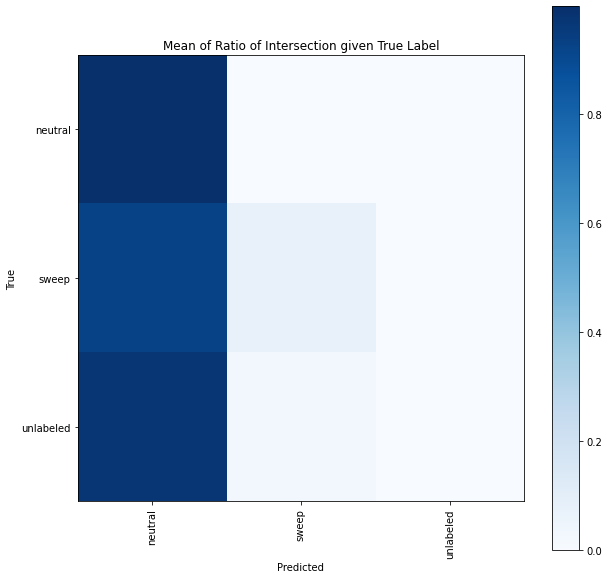

In [51]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [57]:
t = interp.pred_class[10]
print((t==1).nonzero())

tensor([[  0,   0],
        [  0,   1],
        [  0,   2],
        ...,
        [198,  46],
        [198,  47],
        [199,  44]])


In [58]:
t2 = interp.y_true[10]
print((t2==1).nonzero())

tensor([[  0, 199,  42]])


In [ ]:
learn.save('stage-1')

In [59]:
learn2 = unet_learner(data, models.resnet18, metrics=[dice,acc_unlabeled], loss_func=CrossEntropyFlat(axis=1, 
                    weight=torch.tensor([0.5,1.,0.]).cuda()), wd=1e-2)

Here, I weighted sweep pixels as 1 and neutral pixels at 0.5 in the loss function. I thought it might help the model localize the sweep if that was more important than correctly labeling neutral pixels.

epoch,train_loss,valid_loss,dice,acc_unlabeled,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


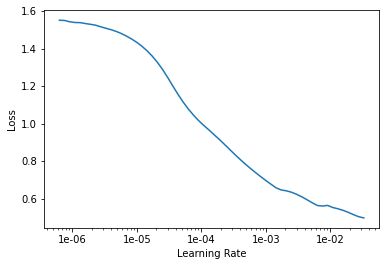

In [63]:
learn2.lr_find()
learn2.recorder.plot()

In [64]:
lr = 3e-5

In [65]:
learn2.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice,acc_unlabeled,time
0,0.657223,0.162042,1.093861,0.989100,01:01
1,0.154652,0.067005,0.531765,0.994625,01:01
2,0.058516,0.037539,0.293835,0.995000,01:01
3,0.036028,0.030938,0.357075,0.994900,01:00
4,0.030358,0.029398,0.374210,0.994925,01:00
5,0.027904,0.027688,0.216987,0.994975,01:00
6,0.026194,0.026718,0.207519,0.994950,01:00
7,0.024442,0.026331,0.178070,0.993750,01:00
8,0.023132,0.026367,0.151293,0.994950,01:00
9,0.020562,0.023598,0.176615,0.994425,01:00


In [75]:
learn2.unfreeze()

In [76]:
lrs = slice(lr/400, lr/4)

In [77]:
learn2.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,acc_unlabeled,time
0,0.018121,0.023729,0.165758,0.994175,01:03
1,0.017878,0.023884,0.158172,0.994325,01:03
2,0.017608,0.024077,0.156663,0.994325,01:02
3,0.017475,0.024188,0.161135,0.994100,01:02
4,0.016784,0.024465,0.150095,0.992675,01:02
5,0.016328,0.024326,0.162568,0.992275,01:03
6,0.015659,0.024779,0.152748,0.993700,01:03
7,0.015120,0.026727,0.150936,0.993150,01:03
8,0.014347,0.026046,0.172314,0.993600,01:02
9,0.013264,0.028867,0.173579,0.994000,01:02


^it started overfitting again during this training cycle

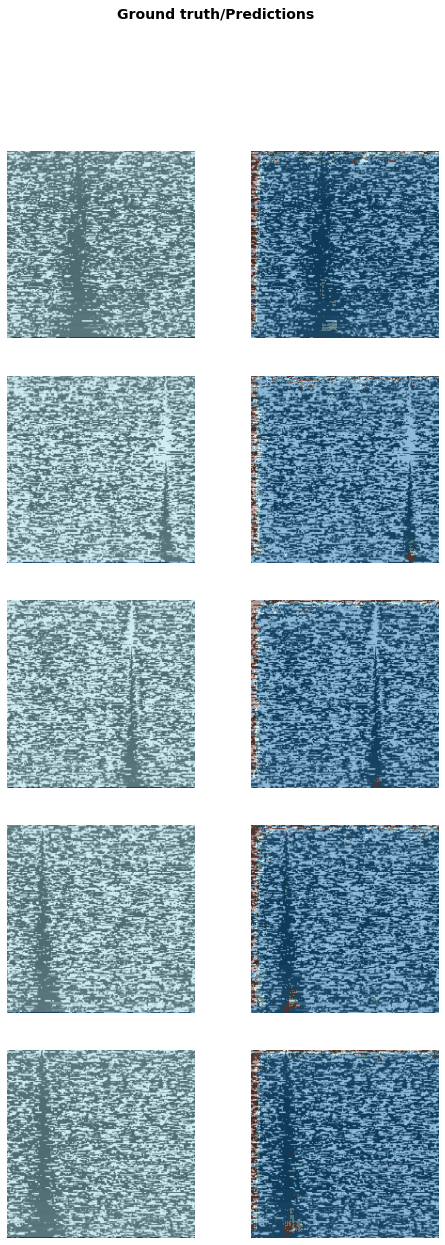

In [82]:
learn2.show_results(6)

Again, it's able to generally localize where the sweep is, though not the exact position. It is still labeling edges as sweep. From visiual inspection, it appears to be labeling fewer incorrect positions as sweep. Also, now it's labeling pixels as unlabeled, which it hadn't done in the previous model.

In [78]:
interp2 = SegmentationInterpretation.from_learner(learn2)

label,score
neutral,0.997211
sweep,0.15
unlabeled,0.0327186


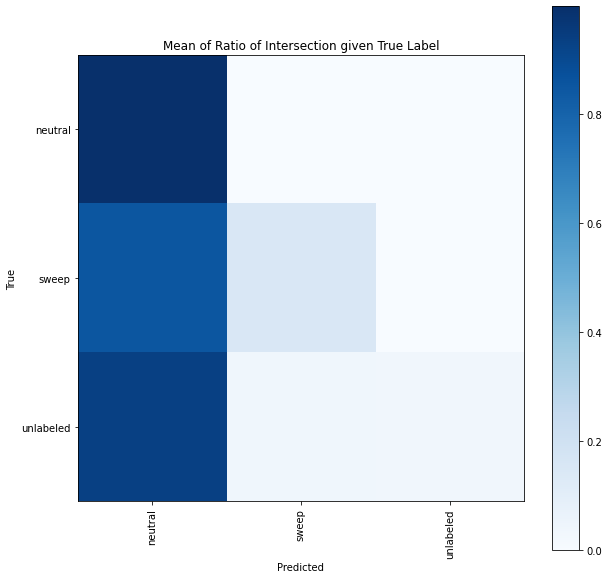

In [79]:
mean_cm, single_img_cm = interp2._generate_confusion()
df = interp2._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

looks like it's getting sweeps in the bottom row correct ~20% of the time. this doesn't incorporate distance of label from correct position, so it's hard to interpret, though.

In [86]:
t = interp2.pred_class[9]
print((t==1).nonzero())

tensor([[  0,   1],
        [  0,   2],
        [  0,   3],
        ...,
        [198, 192],
        [198, 193],
        [199, 192]])


In [87]:
t2 = interp2.y_true[9]
print((t2==1).nonzero())

tensor([[  0, 199, 191]])
